# 1. As características de um problema não-supervisionado

O modelo nao-supervisionado funciona se baseando em convergir a partir da similaridade de atributos entre entidades diferentes. Por exemplo, a partir de frutas com atributos semelhantes (tamanho, cor, formato, etc) o não-supervisionado agrupa. Um dos maiores desafios deste tipo de modelo é que não existe resposta errada, todo algoritmo de clusterização retornará um cluster. Outro desafio é que toda a fundamentação de machine learning se baseia no erro e, por isso, a performance dos modelos são medidos mais na prática. 

Outro ponto importante é que, em geral, clusterização é o meio e não o fim. A ideia é sumarizar os dados por algum motivo. Por exemplo, no caso aqui são os "Insiders", que é um grupo reduzido a partir de um grande grupo. 

# PA 005 - High Value Customer Identification (Insiders)

## 0.0. Planejamento da Solução

1. Problema de Negócio
    - Selecionar os clientes mais valiosos para integrar um programa de fidelização
    
    
2. Conjunto de dados
    - Vendas de um e-commerce online durante um periodo de um ano.

### 0.2. Output (Saída)

1. A indicação das pessoas que farão parte do programa de Insiders
    - Lista: client_id | cluster
    

2. Relatório com as respostas das perguntas de negócio
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

# 0.0 Imports

In [1]:
import pickle

import pandas     as pd
import numpy      as np
import seaborn    as sns
import umap.umap_ as umap

from IPython.display     import HTML
from sklearn.manifold    import TSNE
from pandas_profiling    import ProfileReport
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from plotly      import express       as px
from sklearn     import cluster       as c
from sklearn     import metrics       as m
from sklearn     import ensemble      as en
from sklearn     import decomposition as dd
from sklearn     import preprocessing as pp
from matplotlib  import pyplot        as plt

C:\Users\t.mesha09\Anaconda3\envs\pa005-programa_de_fidelidade\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container {width: 100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Load Dataset

In [3]:
# read data
df_raw = pd.read_csv('../data/Ecommerce.csv', encoding='unicode_escape')

# drop exatra column
df_raw = df_raw.drop('Unnamed: 8', axis=1)

In [4]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 1.0 Descrição dos dados

## 1.1 Rename Columns

In [5]:
df1 = df_raw.copy()

In [6]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [7]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

In [8]:
df1.sample()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
47695,540418,85094,CANDY SPOT EGG WARMER RABBIT,1,5-Jan-17,0.85,NaN,United Kingdom


## 1.2 Data Dimensions

In [9]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'. format(df1.shape[1]))

Number of rows: 541909
Number of columns: 8


## 1.3 Data Types

In [10]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [11]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA

In [12]:
df_missing = df1.loc[df1['customer_id'].isna(),:]
df_not_missing = df1.loc[~df1['customer_id'].isna(),:]

Para os customers_id foi adicionado um valor para não perder as informações de 135 mil clientes. O primeiro id missing que aparecer será o 19001 e assim por diante.

In [13]:
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup),1)

# merge original with reference dataframe
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'])

In [14]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6 Change Dtypes

In [15]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

In [16]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].astype('int64')

In [17]:
df1.sample()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
21997,538149,22144,CHRISTMAS CRAFT LITTLE FRIENDS,4,2016-12-07,4.21,United Kingdom,19179


In [18]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7 Descriptive Statistics

In [19]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [20]:
d = num_attributes.describe()
d1 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d2 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
df_num = pd.concat([d,d1,d2]).T.reset_index()
df_num.columns = ['attributes', 'count', 'mean', 'std','min','25%','50%', '75%', 'max', 'skew', 'kurtosis']
df_num

,attributes,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
0,quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0,-0.264076,119769.160031
1,unit_price,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0,186.506972,59005.719097
2,customer_id,541909.0,16688.840453,2911.411352,12346.00,14367.00,16249.00,18283.00,22709.0,0.487449,-0.804287


#### 1.7.1.1 Numerical Attributes - Investigating

1. Quantity negativa (pode ser devolução)
2. Preço unitário negativo (pode ser promoção?)

### 1.7.2 Categorical Attributes

In [21]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


Alguns invoice_no se encontram com códigos diferentes de números, o que é um pouco estranho e necessita uma avaliação mais aprofundada.

In [22]:
# invoice number
print(f"Total de parâmetros com caracter diferente de número: {len(cat_attributes.loc[cat_attributes['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'invoice_no'].drop_duplicates() ) }")

df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]
print(f'Total de números negativos: {len(df_letter_invoices[df_letter_invoices["quantity"] > 0])}')

Total de parâmetros com caracter diferente de número: 3839
Total de números negativos: 3


Existe um total de 3839 invoice_no que estão com algum tipo de letra no nome, o que impede de fazer a conversão para número. Além disso, todos as quantidades estão negativas nesta situação, o que é estranho, uma vez que os valores de compras precisam ser positivos. Estes valores negativos podem ser considerados devoluções de produtos.

In [23]:
# stock_code
print(len(cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'stock_code'] ))

# total com todos os parametros sendo string
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

54873


array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

Não há indicativo do que são estes stock_code, sendo assim, as linhas que contém estes nomes serão excluídos do dataset.

# 2.0 Data Filtering

In [24]:
df2 = df1.copy()

**Considerações**
- Valores de unit price negativos serão desconsiderados
- Stock Code com palavras que não representem um código serão desconsideradas.
- Clientes na "European Community" ou "Unspecified" serão excluídos (Como não há identificação do país não será utilizado)
- Customers_id com comportamentos muito anormais (analisado na EDA) serão excluídos

In [25]:
# unit price > 0.01
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# stock code != [POST, D, M, DOT, CRUK]
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# description
df2 = df2.drop(columns='description', axis=1)

# map
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# bad users - Pessoas com comportamentos estranho na analise exploratória de dados
df2 = df2[~df2['customer_id'].isin([16446 ])]

## quantity - Negative number means product returns
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchase = df2.loc[df2['quantity'] >= 0, :]

# 3.0 Feature Engineering

In [26]:
df3 = df2.copy()

## 3.1 Feature Creation

In [27]:
df3.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,6,2016-11-29,3.39,United Kingdom,17850


Será criado uma tabela de referência, sendo o customer_id a menor granularidade.

In [28]:
df_ref = df3.drop(['invoice_no', 'stock_code', 
                   'quantity', 'invoice_date', 'unit_price', 
                   'country'], axis = 1).drop_duplicates(ignore_index=True)
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


### 3.1.1 Gross Revenue

In [29]:
# Gross Revenue (Faturamento) = quantity * price
df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:,'quantity']*df2_purchase.loc[:,'unit_price']

# Monetary (Quanto esta pessoa gastou na loja)
df_monetary = df2_purchase.loc[:,['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()

# Adicionando no datafram de referencia
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')
df_ref.isna().sum()

C:\Users\t.mesha09\AppData\Local\Temp\ipykernel_4528\1121802770.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:,'quantity']*df2_purchase.loc[:,'unit_price']


customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2 Recency - Day from last purchase

In [30]:
# Recency - Last Day Purchase
# Como o dataset é antigo, será escolhido a data como a última data de compra do dataset. Esta data servirá de referencia, uma vez que o recorte dos dados é de dois anos atrás.
# em um projeto real, é selecionado o datetime.today(), selecionando assim a data de HOJE.
df_recency = df2_purchase[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2_purchase['invoice_date'].max()-df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3 Quantity of purchased

In [31]:
# Numero de produtos
df_frequency = df2_purchase[['customer_id', 'invoice_no']].groupby('customer_id').count().reset_index().rename(columns={'invoice_no': 'qtde_invoices'})
df_ref = pd.merge(df_ref, df_frequency, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
dtype: int64

### 3.1.4 Quantity of items purchased

In [32]:
# soma de itens
df_frequency = df2_purchase[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity': 'qtde_itens'})
df_ref = pd.merge(df_ref, df_frequency, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_itens       91
dtype: int64

### 3.1.5 Quantity of products purchased

In [33]:
# quantidade de produtos comprados
df_frequency = df2_purchase[['customer_id', 'stock_code']].groupby('customer_id').count().reset_index().rename(columns={'stock_code': 'qtde_produtos'})
df_ref = pd.merge(df_ref, df_frequency, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_itens       91
qtde_produtos    91
dtype: int64

### 3.1.5 Average Ticket Value

In [34]:
# Avg Ticket
df_avg_ticket = df2_purchase[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
df_avg_ticket['avg_ticket'] = np.round(df_avg_ticket['avg_ticket'],2)
df_ref = pd.merge(df_ref, df_avg_ticket, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_itens       91
qtde_produtos    91
avg_ticket       91
dtype: int64

### 3.1.6 Average Recency Days

In [35]:
# media de tempo entre as compras

In [36]:
# average recency days
df_aux = df2[['customer_id','invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending=[True, True])
df_aux['next_customer_id'] = df_aux['customer_id'].shift() #next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoice date

df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['invoice_date'] - x['previous_date']).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1)

df_aux.drop(['invoice_date', 'next_customer_id', 'previous_date'], axis=1).dropna()

# average recency
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

# merge
df_ref = pd.merge(df_ref, df_avg_recency_days, on='customer_id', how='left')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_itens            91
qtde_produtos         91
avg_ticket            91
next_customer_id       1
avg_recency_days    2816
dtype: int64

### 3.1.7 Frequency Purchase

In [37]:
df_aux = (df2_purchase[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                            .groupby('customer_id')
                                                            .agg(max_  = ('invoice_date', 'max'), 
                                                                 min_  = ('invoice_date', 'min'), 
                                                                 days_ = ('invoice_date', lambda x: (x.max() - x.min()).days +1),
                                                                 buy_  = ('invoice_no', 'count') )  ).reset_index()

# frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1)

# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left') 
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_itens            91
qtde_produtos         91
avg_ticket            91
next_customer_id       1
avg_recency_days    2816
frequency             91
dtype: int64

### 3.1.8 Number of Returns

In [38]:
# number of returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity': 'qtde_returns'})
df_returns['qtde_returns'] = df_returns['qtde_returns']*(-1)

df_ref = pd.merge(df_ref, df_returns, how='left', on='customer_id')
df_ref.loc[df_ref['qtde_returns'].isna(),'qtde_returns'] = 0

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_itens            91
qtde_produtos         91
avg_ticket            91
next_customer_id       1
avg_recency_days    2816
frequency             91
qtde_returns           0
dtype: int64

### 3.1.9 Basket Size - Quantidade de itens por cesta (quantity)

In [39]:
# Em media, quantas pessoas compram quando vão ao mercado

In [40]:
df_aux = (df2_purchase.loc[:, ['customer_id', 'invoice_no','quantity']].groupby('customer_id')
                                                                         .agg(n_purchase=('invoice_no', 'nunique'),
                                                                              n_products=('quantity','sum')) 
                                                                         .reset_index())
# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_itens            91
qtde_produtos         91
avg_ticket            91
next_customer_id       1
avg_recency_days    2816
frequency             91
qtde_returns           0
avg_basket_size       91
dtype: int64

### 3.1.10 Unique Basket Size = Quantidade de produtos distintos por compra

In [41]:
df_aux = (df2_purchase.loc[:, ['customer_id', 'invoice_no','stock_code']].groupby('customer_id')
                                                                         .agg(n_purchase=('invoice_no', 'nunique'),
                                                                              n_products=('stock_code','nunique')) 
                                                                         .reset_index())

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id')
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtde_invoices               91
qtde_itens                  91
qtde_produtos               91
avg_ticket                  91
next_customer_id             1
avg_recency_days          2816
frequency                   91
qtde_returns                 0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

In [42]:
df_ref.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_itens,qtde_produtos,avg_ticket,next_customer_id,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,297.0,1733.0,297.0,18.15,17849.666667,35.500000,17.000000,40.0,50.970588,0.617647
1,13047,3232.59,56.0,171.0,1390.0,171.0,18.90,13046.923077,27.250000,0.028302,35.0,154.444444,11.666667
2,12583,6705.38,2.0,232.0,5028.0,232.0,28.90,12582.941176,23.187500,0.040323,50.0,335.200000,7.600000
3,13748,948.25,95.0,28.0,439.0,28.0,33.87,13747.750000,92.666667,0.017921,0.0,87.800000,4.800000
4,15100,876.00,333.0,3.0,80.0,3.0,292.00,15099.833333,8.600000,0.073171,22.0,26.666667,0.333333


# 4.0 EDA - Exploratory Data Analysis

In [43]:
df4 = df_ref.dropna().copy()

In [44]:
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtde_invoices             0
qtde_itens                0
qtde_produtos             0
avg_ticket                0
next_customer_id          0
avg_recency_days          0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## 4.1 Univariate Analysis

**Notas**
Em modelos de clusterização, as ideias principais são:

    1. Encontrar clusters coesos e separado
    2. Entender métricas como: 
        - Mínimo, Máximo, Range (dispersão)
        - Média e Mediana 
        - Desvio Padrão e Variância
        - Coeficiente de Variação (desvio padrão dividido pela média)
        - Distribuição

In [45]:
#profile = ProfileReport(df4)
#profile.to_file('output_V2.html')

**PROFILE retirado por exceder o espaço do Github!**

**Analisando outliers**

### 4.1.1 Gross Revenue

In [46]:
df4.sort_values('gross_revenue', ascending=False).head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_itens,qtde_produtos,avg_ticket,next_customer_id,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,2060.0,196844.0,2060.0,135.50,14645.978261,7.844444,0.203390,288.0,2733.944444,9.708333
492,18102,259657.30,0.0,431.0,64124.0,431.0,602.45,18101.961538,14.680000,0.163043,0.0,1068.733333,2.500000
433,17450,194550.79,8.0,337.0,69993.0,337.0,577.30,17449.965517,12.821429,0.127778,952.0,1521.586957,2.695652
66,14911,140450.72,1.0,5673.0,80263.0,5673.0,24.76,14910.993056,2.601399,0.533512,3332.0,403.331658,8.974874
1150,12415,124564.53,24.0,713.0,77373.0,713.0,174.70,12414.937500,20.866667,0.063694,427.0,3868.650000,22.150000


In [47]:
df4[df4['customer_id'] == 14646].head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_itens,qtde_produtos,avg_ticket,next_customer_id,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,2060.0,196844.0,2060.0,135.5,14645.978261,7.844444,0.20339,288.0,2733.944444,9.708333


Apesar de um gross revenue muito alto, nada indica aqui que há um erro com este cliente, apenas um outlier que pode ser interessante para o cluster insider.

### 4.1.2 Qtde Itens

In [48]:
df4.sort_values('qtde_itens', ascending=False).head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_itens,qtde_produtos,avg_ticket,next_customer_id,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,2060.0,196844.0,2060.0,135.50,14645.978261,7.844444,0.203390,288.0,2733.944444,9.708333
66,14911,140450.72,1.0,5673.0,80263.0,5673.0,24.76,14910.993056,2.601399,0.533512,3332.0,403.331658,8.974874
1150,12415,124564.53,24.0,713.0,77373.0,713.0,174.70,12414.937500,20.866667,0.063694,427.0,3868.650000,22.150000
433,17450,194550.79,8.0,337.0,69993.0,337.0,577.30,17449.965517,12.821429,0.127778,952.0,1521.586957,2.695652
15,17511,91062.38,2.0,963.0,64549.0,963.0,94.56,17510.969697,11.593750,0.083333,1535.0,2082.225806,14.612903


Apesar de um valor muito alto, o cliente é o mesmo do gross revenue e não há nada de estranho, pode ser um usuário que compre muito (o dobro o segundo)

### 4.1.3 Avg Ticket

In [49]:
df4[df4['avg_ticket'] == 56157.5]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_itens,qtde_produtos,avg_ticket,next_customer_id,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size


Um ponto a ser analisado é que o cliente comprou 80997 itens, porém, devolveu 80995. É necessário entender melhor o que houve, para isso, será observado as principais compras.

In [50]:
df3[df3['customer_id'] == 16446]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id


Nesta situação, o cliente no dia 2017-05-16 fez duas compras, uma no valor de 1.65 e outra no valor de 1.25. Algum tempo depois ele comprou 80995 itens e no mesmo dia devolveu esta quantidade. É importante pontuar com o time de negócio para entender se é necessário manter alguém com tanta devolução no dataset ou se é necessário apenas excluí-lo. 

### 4.1.4 Frequency

In [51]:
df4[df4['frequency'] == 17]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_itens,qtde_produtos,avg_ticket,next_customer_id,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,297.0,1733.0,297.0,18.15,17849.666667,35.5,17.0,40.0,50.970588,0.617647


In [52]:
df3[df3['customer_id'] == 17850].sort_values('quantity', ascending=False).head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
4528,536790,84406B,12,2016-11-30,2.75,United Kingdom,17850
4162,536750,71053,12,2016-11-30,3.39,United Kingdom,17850
3808,536685,85123A,12,2016-11-30,2.55,United Kingdom,17850
4526,536790,85123A,12,2016-11-30,2.95,United Kingdom,17850
4527,536790,71053,12,2016-11-30,3.39,United Kingdom,17850


Apesar de uma frequência alta se comparado com outros valores, nenhum comportamento estranho é encontrado aqui.

### 4.1.5 Avg Basket Size

In [53]:
df4[df4['avg_basket_size'] == 40498.5]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_itens,qtde_produtos,avg_ticket,next_customer_id,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size


É o mesmo outlier anterior, será retirado do dataset.

## 4.2 Bivariate Analysis

In [54]:
cols = ['customer_id']
df42 = df4.drop(cols, axis=1)

<Figure size 1800x864 with 0 Axes>

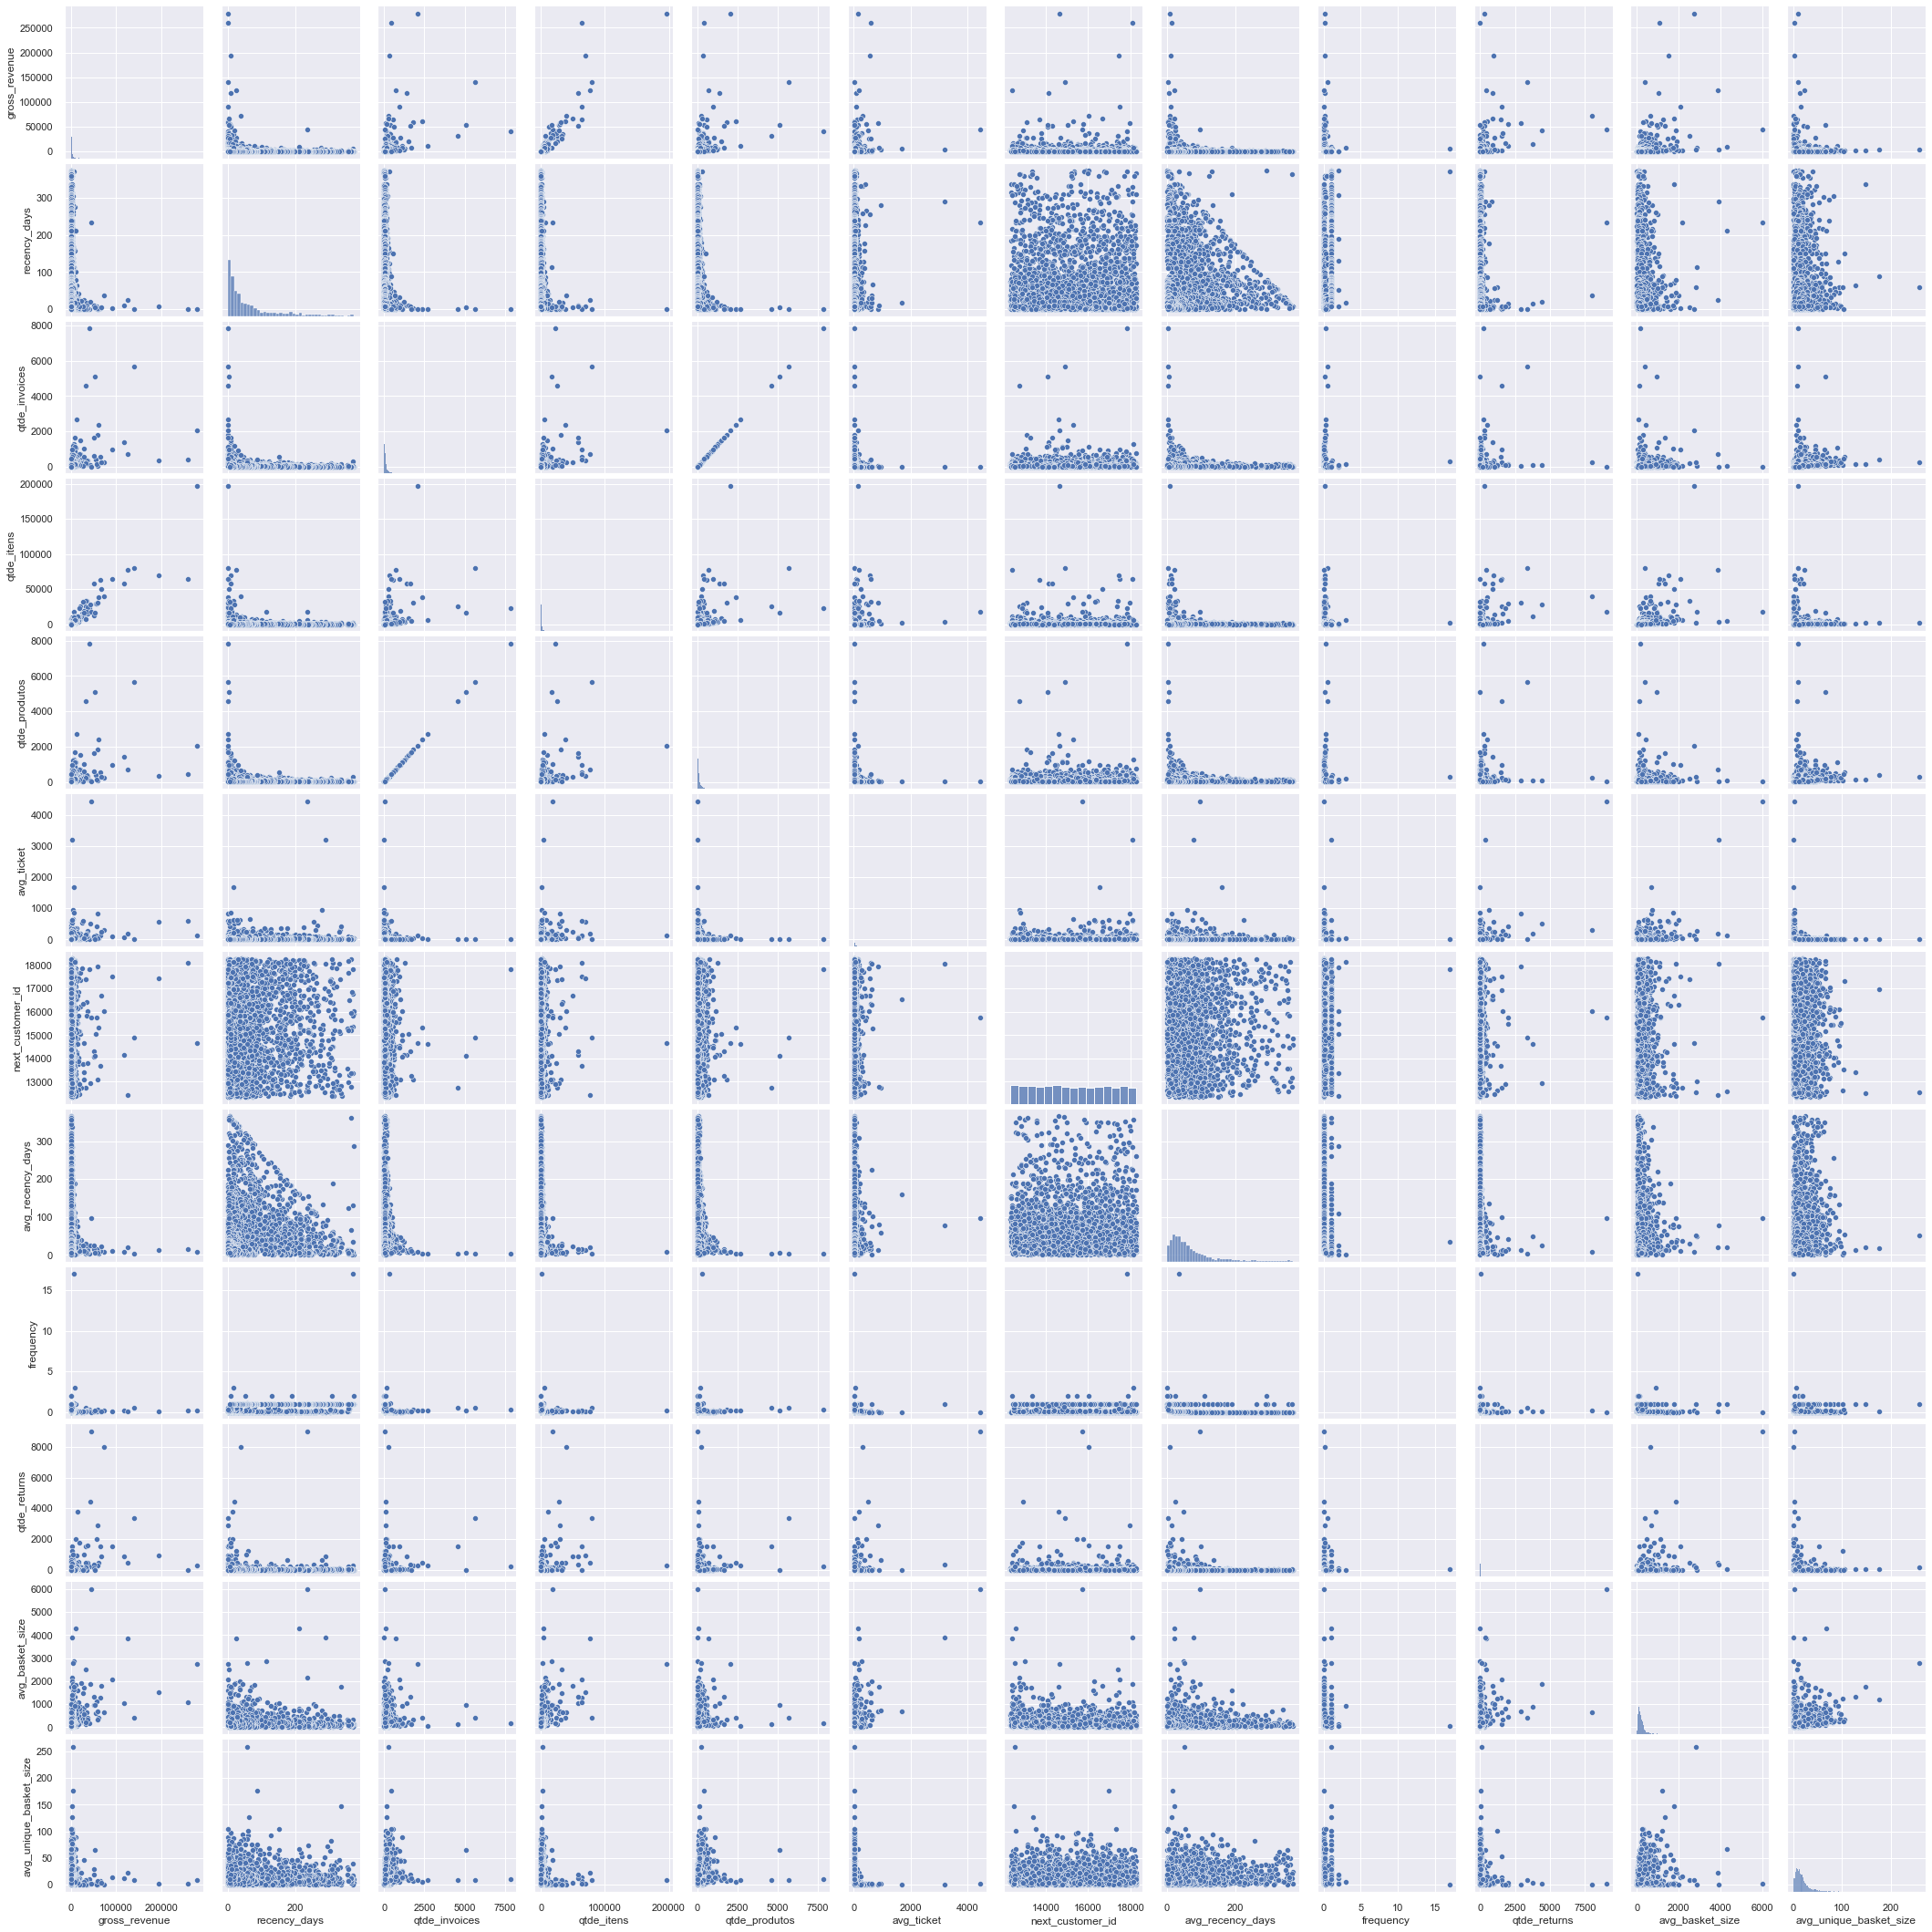

In [55]:
plt.figure(figsize=(25,12))
sns.pairplot(df42)

Observando a frequencia, é possível notar que não há uma variabilidade ao fazer o gráfico dela em relação as outras features. Este é um indício de uma variável irrelevante para os modelos de clusterização. 
Avg Ticket também segue a mesma ideia de pouca variação.

## 4.3 Estudo de Espaço de Features

O espaço de features é formado pelos registros (linhas) e as features (colunas). Este espaço de features monta alguns clusters que podem estar misturados. Por exemplo, Frequência x Recência, um cliente com frequência alta e recência baixa pode estar no mesmo cluster com frequência baixa e recência alta. Para fazer esta clusterização mais complexa é possível utilizar um espaço de embedding.

O espaço de embedding é um espaço desconhecido. Quando os pontos são transportados para este novo espaço há uma nova organização das linhas e colunas. Existe duas formas de construir este espaço novo, a primeira é utilizando algebra linear e a segunda utilizando algoritmos de machine learning. Um destes algoritmos é o PCA, ela torna as features novas como combinações lineares de outras features. Outro algoritmo é utilizando decision trees. Quando a árvore constrói a separação, as folhas das arvores são os espaços de embbeding. Além dessas, o UMEP e o t-SNE também criam espaços de embedding. 

In [56]:
#df43 = df4.drop(columns=['customer_id', 'next_customer_id'], axis=1).copy()
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_produtos', 'frequency', 'qtde_returns']
df43 = df4[cols_selected].copy()

In [57]:
df43.columns

Index(['customer_id', 'gross_revenue', 'recency_days', 'qtde_produtos',
       'frequency', 'qtde_returns'],
      dtype='object')

In [58]:
mm = pp.MinMaxScaler()

df43['gross_revenue']          = mm.fit_transform(df43[['gross_revenue']])
pickle.dump(mm, open('../data/models/gross_revenue_scaler.pkl', 'wb'))

df43['recency_days']           = mm.fit_transform(df43[['recency_days']])
pickle.dump(mm, open('../data/models/recency_days_scaler.pkl', 'wb'))

df43['qtde_produtos']          = mm.fit_transform(df43[['qtde_produtos']])
pickle.dump(mm, open('../data/models/qtde_produtos_scaler.pkl', 'wb'))

df43['frequency']              = mm.fit_transform(df43[['frequency']])
pickle.dump(mm, open('../data/models/frequency_scaler.pkl', 'wb'))

df43['qtde_returns']           = mm.fit_transform(df43[['qtde_returns']])
pickle.dump(mm, open('../data/models/qtde_returns.pkl', 'wb'))

X = df43.copy()

In [59]:
df43.head()

,customer_id,gross_revenue,recency_days,qtde_produtos,frequency,qtde_returns
0,17850,0.019292,0.997319,0.037770,1.000000,0.004438
1,13047,0.011559,0.150134,0.021692,0.001345,0.003883
2,12583,0.024000,0.005362,0.029476,0.002052,0.005547
3,13748,0.003375,0.254692,0.003445,0.000734,0.000000
4,15100,0.003116,0.892761,0.000255,0.003985,0.002441


### 4.3.1 PCA

In [60]:
X.shape[1]

6

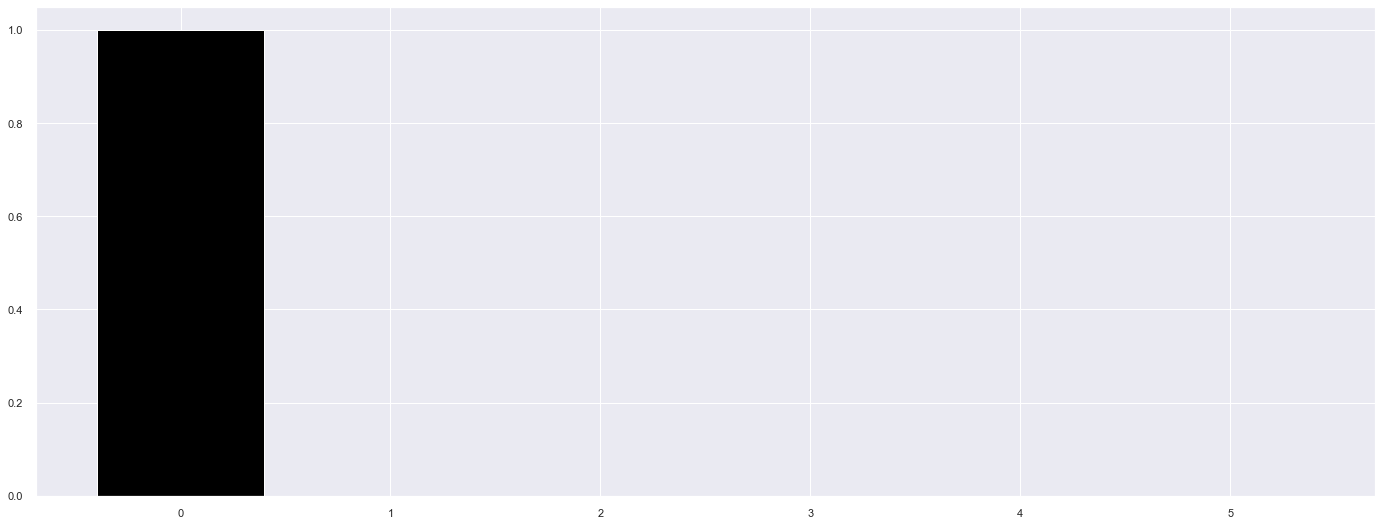

In [61]:
pca = dd.PCA(n_components=X.shape[1])

principal_components = pca.fit_transform(X)

# plot explained variable
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='black')

#pca component
df_pca = pd.DataFrame(principal_components)

O gráfico indica quais são os principais componentes com maior variação de dados. 

<AxesSubplot:xlabel='0', ylabel='1'>

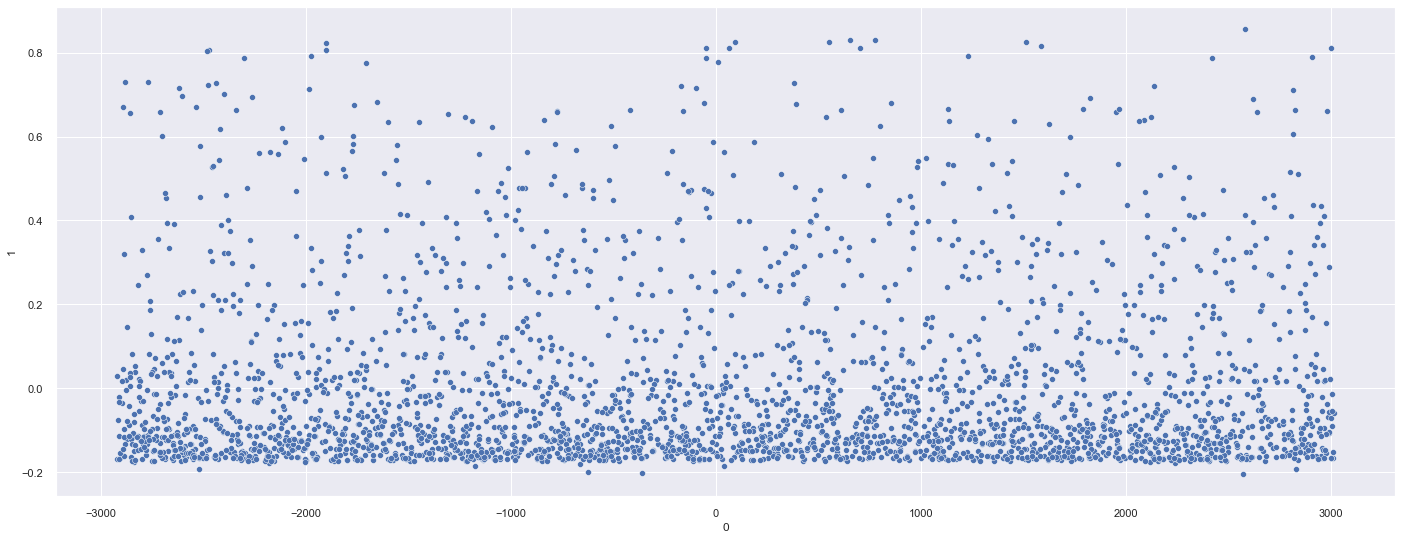

In [62]:
sns.scatterplot(x=0, y=1, data=df_pca)

Ou seja, não é possível observar nenhum cluster formado utilizando o PCA.

### 4.3.2 UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

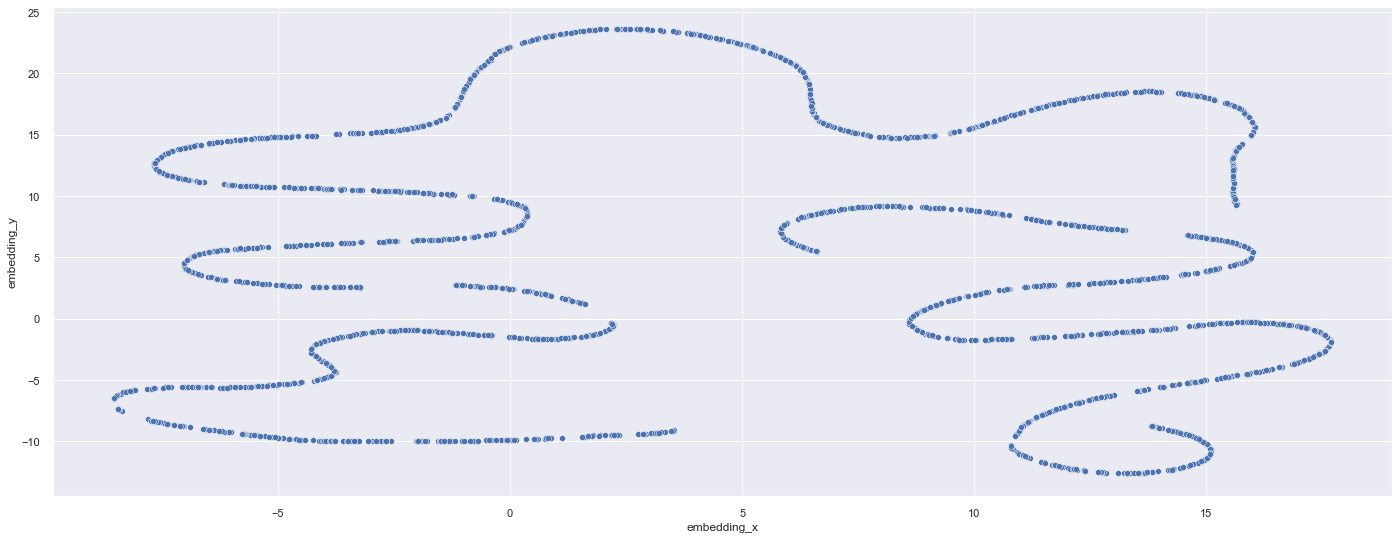

In [63]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y',  
                data=df_pca)

Um pouco melhor que o PCA, o UMAP gera alguns clusters, mas são muito próximos e difíceis e distinguir.

### 4.3.3 t-SNE

C:\Users\t.mesha09\Anaconda3\envs\pa005-programa_de_fidelidade\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\t.mesha09\Anaconda3\envs\pa005-programa_de_fidelidade\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

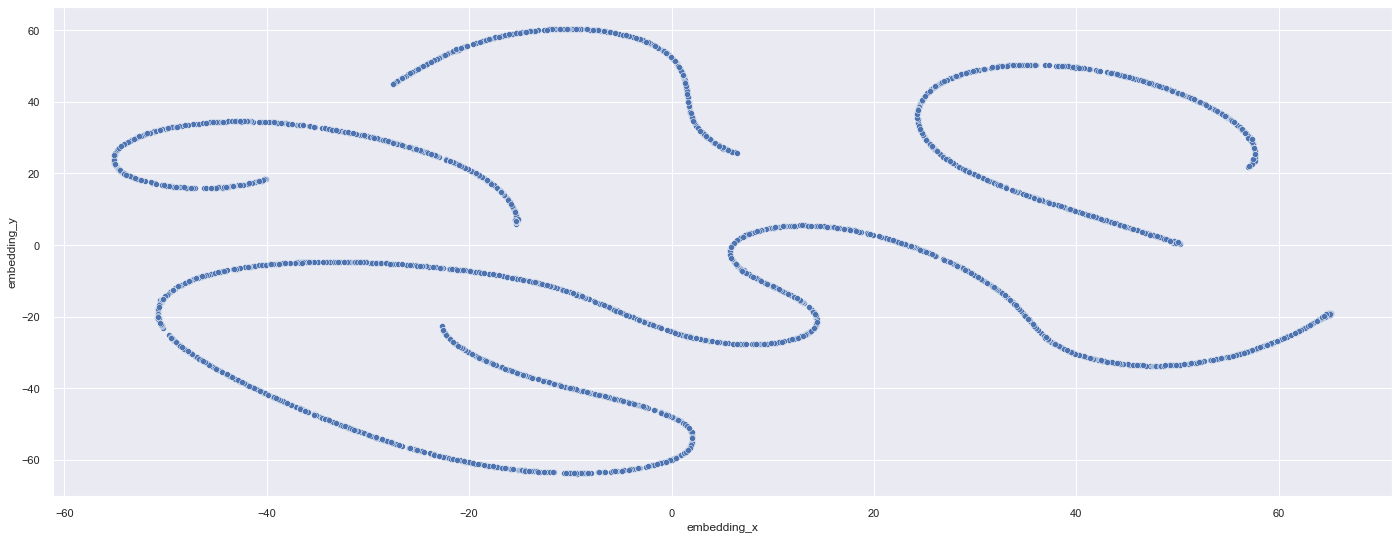

In [64]:
reducer = TSNE(n_components=2, random_state=42, n_jobs=-1)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y',  
                data=df_pca)

O t-SNE forma clusters mais espalhados e muito grandes.

### 4.3.3 Tree-Based Embedding

In [65]:
X.head()

,customer_id,gross_revenue,recency_days,qtde_produtos,frequency,qtde_returns
0,17850,0.019292,0.997319,0.037770,1.000000,0.004438
1,13047,0.011559,0.150134,0.021692,0.001345,0.003883
2,12583,0.024000,0.005362,0.029476,0.002052,0.005547
3,13748,0.003375,0.254692,0.003445,0.000734,0.000000
4,15100,0.003116,0.892761,0.000255,0.003985,0.002441


Aqui vai ser definido que a variável gross_revenue é a variável "resposta", uma vez que está se tratando de um modelo não supervisionado e não existe variável resposta. A escolha desta variável se dá porque no final das contas o cluster Insider tem como principal característica pessoas que compram mais, assim, usar a gross_revenue faz sentido do ponto de vista de negócio.

In [66]:
# training dataset
X = df43.drop(columns = ['customer_id', 'gross_revenue'])
y = df43['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor(random_state=42, n_estimators=100)

# model training
rf_model.fit(X, y)
pickle.dump(rf_model, open('../data/models/rf_model.pkl', 'wb'))

# leaf

#dataframe leaf

In [67]:
df_leaf = pd.DataFrame(rf_model.apply(X))

In [68]:
df_leaf.shape

(2968, 100)

In [69]:
df_leaf.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,3466,3439,3726,3677,3655,3752,3613,3688,3684,3492,3668,3543,3545,3578,3553,3490,3318,3422,3409,3246,3527,3655,3637,3582,3500,3427,3283,3394,3394,3764,3305,3609,3338,3458,3563,3393,3487,3654,3460,3620,3502,3624,3646,3675,3414,3437,3500,3742,3595,3380,3567,3545,3517,3394,3744,3697,3394,3656,3437,3696,3486,3483,3534,3761,3636,3490,3498,3563,3515,3522,3710,3736,3642,3706,3713,3513,3647,3564,3649,3412,3577,3546,3505,3672,3467,3629,3666,3689,3626,3409,3450,3392,3423,3679,3588,3706,3669,3406,3624,3653
1,3339,3394,3600,3055,3024,2971,3153,3515,3314,3246,3048,3445,3306,3396,3497,3412,3291,3281,3324,3175,3359,3526,2894,2897,3370,3221,3274,3303,3253,3157,3244,3364,3321,3311,3318,3373,3372,3138,3059,3059,3359,3170,3065,3126,3381,3412,3298,3264,3340,3255,3151,3428,3509,2992,3511,3103,3333,3648,3202,3231,3361,3301,2966,3152,3451,3209,3067,2860,3414,3257,3182,3108,3163,2701,3292,3124,3227,3431,3367,3391,3282,3272,3369,3533,3340,3069,3279,3155,3045,3383,2810,3270,3058,2943,3404,2996,2976,3304,3025,3508
2,3513,2982,3627,3580,3555,3652,3284,3551,3329,3332,3614,3473,3422,3517,3470,3471,3023,3362,3449,3238,3476,3520,3261,3246,3401,3383,3030,3350,3206,3661,3248,3393,3299,3495,3514,3468,3534,3580,3484,3538,3554,3224,3553,3562,3316,3424,3355,3242,3542,3382,3558,3500,3452,3469,3567,3645,3486,3534,3210,3310,3493,3440,3522,3639,3490,3443,3250,3560,3458,3001,3645,3648,3655,3622,3053,3509,3274,3507,3397,3078,3261,3220,3394,3560,3406,3560,3290,3715,3333,3430,3420,3341,3479,3530,3527,3592,3044,3382,3539,3584
3,1084,543,1214,309,854,346,537,933,1296,1233,814,362,569,466,1075,820,927,719,381,1104,564,393,1254,412,465,587,1231,646,1162,326,621,544,1211,985,1159,1041,1426,397,399,1281,591,1260,1031,540,1136,892,588,469,722,971,407,386,1115,601,1504,1153,313,531,785,674,648,970,996,1265,1148,315,494,869,323,1107,673,1254,360,1470,1252,665,607,1209,1236,387,1163,1135,1042,1158,374,969,978,957,750,1112,538,1545,576,600,1057,1308,568,523,924,891
4,436,632,377,889,911,778,1020,37,562,485,143,511,50,714,528,461,544,1102,719,574,688,91,135,712,889,740,83,923,544,1690,59,652,596,335,473,493,361,1240,717,736,676,752,620,68,528,387,784,647,987,731,825,706,322,1020,536,496,1024,95,122,1212,1059,716,591,499,543,622,603,359,631,600,959,774,948,86,106,911,974,512,502,652,53,104,105,717,659,508,493,725,1055,506,894,611,877,700,764,468,689,882,1316,461
5,2764,3285,2763,2938,3043,2853,2299,2413,3293,2780,3097,2747,2935,2859,2931,2509,2931,2302,2864,2421,2888,2880,3240,3190,2922,2447,2399,2759,2413,3046,2436,2797,2493,2570,2455,2450,2791,2954,3038,2423,2937,3086,3118,2957,2449,2352,2416,2484,2519,2420,2967,2482,2843,2483,2654,2895,2524,2458,2352,2925,2591,2462,3038,3139,2856,2264,2414,2965,2452,2505,2948,2867,3146,2968,2440,3002,3172,2775,2521,2488,2398,3192,2911,2889,2851,2466,3123,3187,2444,2710,2735,2823,3029,2866,2906,2974,2522,2343,2976,2485
6,3543,3512,3637,3712,3599,3688,3678,3598,3800,3504,3700,3616,3585,3567,3530,3500,3683,3485,3472,3540,3602,3641,3682,3660,3547,3676,3629,3453,3683,3783,3666,3710,3623,3528,3538,3711,3595,3597,3620,3577,3581,3658,3761,3723,3489,3523,3473,3649,3582,3704,3707,3514,3466,3511,3653,3660,3519,3627,3439,3659,3566,3473,3639,3673,3624,3481,3366,3674,3477,3638,3697,3673,3700,3632,3670,3552,3694,3614,3511,3491,3657,3647,3563,3609,3632,3683,3705,3735,3663,3497,3489,3613,3502,3555,3569,3633,3681,3661,3559,3613
7,2472,2285,1801,1193,1838,2018,1925,2383,1092,1987,1253,2185,1627,1864,963,2501,1925,2455,1436,2136,1825,1718,2303,1323,1597,1984,2334,1687,2211,1615,2419,1754,2408,2254,2434,2434,1809,1996,1163,2429,1834,2197,2892,1503,2208,2337,1701,2222,2483,2337,2207,1593,1667,2461,1027,1571,2467,2934,2439,2868,2107,2292,2346,1984,1930,2272,1798,1679,1823,2441,1809,15

Cada coluna é uma decision tree que escolheu um customer (linhas) para uma folha específica. Ou seja, a árvore "0", colocou o customer "0" no index da folha "2984", já a árvore "1", colocou este mesmo customer no index da folha "2726" e assim por diante. Ou seja, cada vez que se varia as features, o usuário cai em uma árvore diferente, gerando assim, um novo espaço de 100 dimensões. Para ver isto é necessário fazer uma redução de dimensionalidade. 

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

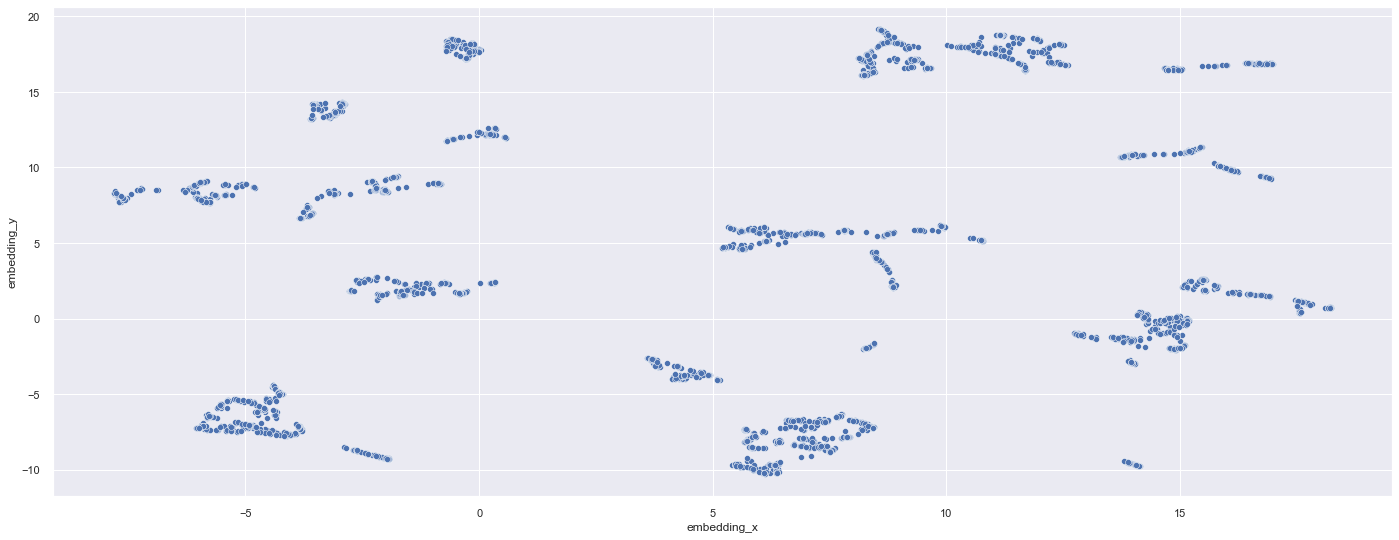

In [70]:
# reducer dimensionality
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)

pickle.dump(reducer, open('../data/models/umap_reducer.pkl', 'wb'))

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:,0]
df_tree['embedding_y'] = embedding[:,1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y',  
                data=df_tree)

A árvore criou espaço bem distintos e separados, onde agora os algoritmos serão rodados. O ponto negativo é que neste tipo de espaço perde-se a explicabilidade do modelo. Em um espaço euclidiano, observa-se as variáveis e tira-se conclusões fáceis dos agrupamentos, coisa que se perde aqui. 

# 5.0 Data Preparation

In [71]:
 #df5 = df4.copy() 
df5 = df_tree.copy()

In [72]:
df5.head()

,embedding_x,embedding_y
0,10.603584,18.021975
1,15.192944,11.075175
2,11.436817,18.614090
3,-1.617732,2.295417
4,-5.436786,8.880532


# 6.0 Feature Selection

In [73]:
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_produtos', 'frequency', 'qtde_returns']

In [74]:
df6 = df_tree.copy()

# 7.0 Hyperparameter Fine-Tuning

In [75]:
df_tree.head()

,embedding_x,embedding_y
0,10.603584,18.021975
1,15.192944,11.075175
2,11.436817,18.614090
3,-1.617732,2.295417
4,-5.436786,8.880532


In [76]:
#X = df6.drop(columns=['customer_id'])
X = df_tree.copy()

In [77]:
X.head()

,embedding_x,embedding_y
0,10.603584,18.021975
1,15.192944,11.075175
2,11.436817,18.614090
3,-1.617732,2.295417
4,-5.436786,8.880532


In [78]:
#clusters = [2,3,4,5,6,7]
clusters = np.arange(2,26,1)

## 7.1 K-Means

In [79]:
kmeans_list = []
for k in clusters:
# model definition
    kmeans_model = c.KMeans(n_clusters=k)

    # model training
    kmeans_model.fit(X)

    # model predict
    labels = kmeans_model.predict(X)

    # model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    kmeans_list.append(sil)

Text(0.5, 1.0, 'Silhouette Score x K')

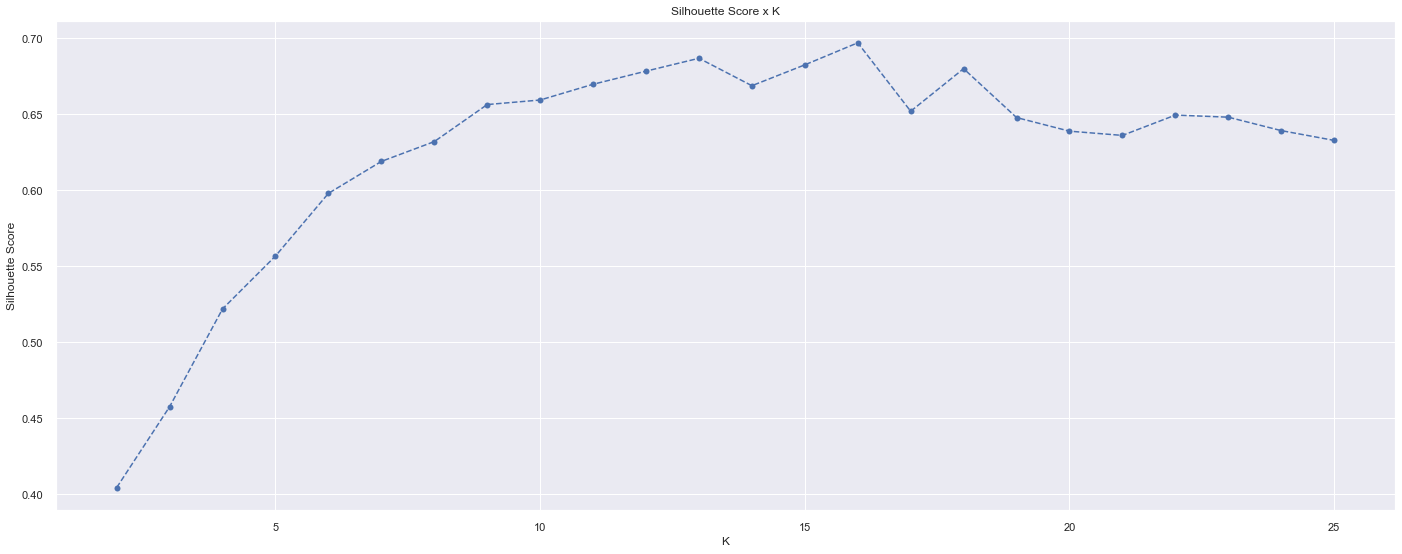

In [80]:
plt.plot(clusters, kmeans_list, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score x K')

## 7.2 GMM

In [81]:
from sklearn import mixture as mx

In [82]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components=k)

    # model training
    gmm_model.fit(X)

    # model predict
    labels = gmm_model.predict(X)
    # model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    gmm_list.append(sil)

Text(0.5, 1.0, 'Silhouette Score x K')

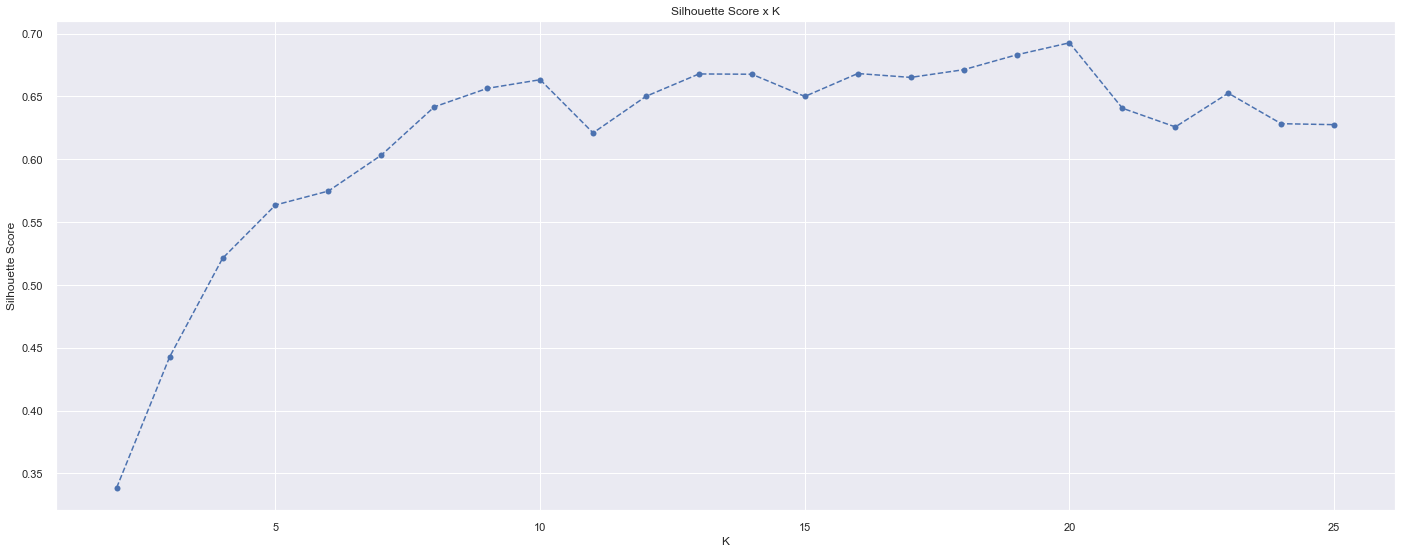

In [83]:
plt.plot(clusters,gmm_list, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score x K')

## 7.3 Hierarchical Clustering

In [84]:
from scipy.cluster import hierarchy as hc

In [85]:
# model definition and training
hc_model = hc.linkage(X, method='ward')

In [86]:
#hc.dendrogram(hc_model, leaf_rotation=90, leaf_font_size=15)

#plt.plot()

In [87]:
#hc.dendrogram(hc_model, truncate_mode='lastp', p=12, leaf_rotation=90, leaf_font_size=8, show_contracted=True)
#plt.plot()

### 7.3.1 HClustering Silhouette Score

In [88]:
hc_list = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage(X,'ward')

    # model predict
    label = hc.fcluster(hc_model, k, criterion='maxclust')

    # metrics
    sil = m.silhouette_score(X, label, metric='euclidean')
    hc_list.append(sil)

In [89]:
hc_list

[0.3692019,
 0.44812712,
 0.51913315,
 0.5634824,
 0.5628099,
 0.61901367,
 0.63206184,
 0.6564533,
 0.6594352,
 0.66980743,
 0.6784476,
 0.69029915,
 0.6987707,
 0.6825915,
 0.6694334,
 0.6655569,
 0.68007416,
 0.66267735,
 0.6415634,
 0.6505239,
 0.65896267,
 0.65069187,
 0.6378843,
 0.6351874]

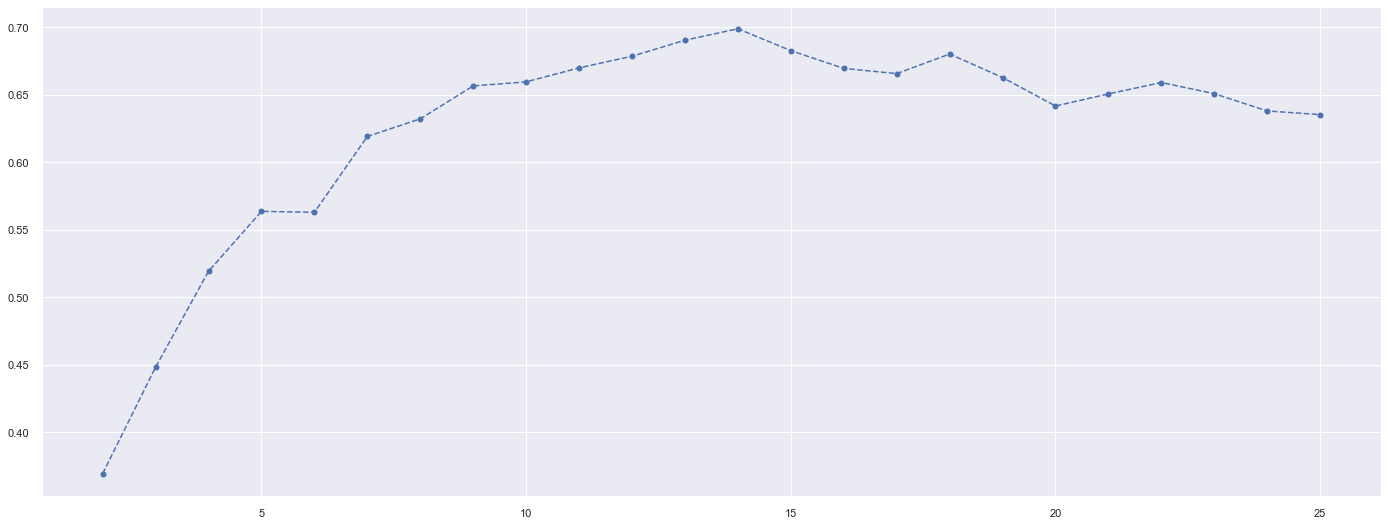

In [90]:
plt.plot(clusters, hc_list, linestyle='--', marker='o', color='b')

## 7.4 DBSCAN

**O DBSCAN está errado**

In [91]:
#eps=0.2
#min_samples=2

## model definition

#dbscan_model = c.DBSCAN(eps=eps, min_samples=min_samples)

## model training & predict
#labels = dbscan_model.fit_predict(X)

#sil = m.silhouette_score(X, labels, metric='euclidean')
#sil

In [92]:
#unique(labels)

In [93]:
#from sklearn.neighbors import NearestNeighbors

In [94]:
#neighbors = NearestNeighbors(n_neighbors=min_samples).fit(X)
#distances, indices = neighbors.kneighbors(X)

In [95]:
#dbscan_list = [0.622034, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000]

## 7.5 Results

In [96]:
df_results = pd.DataFrame({'Kmeans': kmeans_list,
                           'GMM': gmm_list,
                           'HC': hc_list
                           #'DBSCAN': dbscan_list
                          }).T 
df_results.columns = clusters

In [97]:
df_results.style.highlight_max(color='lightgreen', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
Kmeans,0.404283,0.457538,0.521927,0.556727,0.597989,0.619014,0.632062,0.656453,0.659435,0.669807,0.678448,0.686919,0.668853,0.682591,0.697109,0.652037,0.680066,0.647889,0.638927,0.636133,0.649511,0.648139,0.639293,0.632851
GMM,0.338686,0.442678,0.521167,0.563622,0.574733,0.603316,0.641727,0.656453,0.663354,0.621020,0.650130,0.667944,0.667709,0.650048,0.668277,0.665192,0.671319,0.683146,0.692739,0.640650,0.625780,0.652647,0.628340,0.627575
HC,0.369202,0.448127,0.519133,0.563482,0.562810,0.619014,0.632062,0.656453,0.659435,0.669807,0.678448,0.690299,0.698771,0.682591,0.669433,0.665557,0.680074,0.662677,0.641563,0.650524,0.658963,0.650692,0.637884,0.635187


## 7.3 Silhouette Analysis

In [98]:
#fig,ax = plt.subplots(3,2)
#fig.set_size_inches(25,20)

#for k in clusters:
#    q, mod = divmod(k,2)
    
#    ax[q-1,mod].set_xlim([-0.1,1])
#    ax[q-1,mod].set_ylim([0, len(X) + (k+1)*10])
    
    # model definition & training
#    hc_model = hc.linkage(X,'ward')
  
    # model predict
#    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # performance
#    ss = m.silhouette_score(X, labels, metric='euclidean')
#    print('For K = {} -> Silhouette Score: {}'.format(k,ss))
    
#    samples_silhoutte_values = m.silhouette_samples(X, labels)
    
#    y_lower = 10
#    for i in range(k):

        

        # select clusters
#        ith_samples_silhouette_values = samples_silhoutte_values[labels==i] 
        
        # sort values
#        ith_samples_silhouette_values.sort()
        
        # size clusters
#        size_cluster_i = ith_samples_silhouette_values.shape[0]
#        y_upper = y_lower + size_cluster_i
        
#        cmap = cm.get_cmap('Spectral')
#        color = cmap(i/k)
        
#        ax[q-1,mod].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_samples_silhouette_values)
#        y_lower = y_upper + 10
    
#    ax[q-1, mod].set_yticks([])
#    ax[q-1, mod].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [99]:
#fig,ax = plt.subplots(3,2,figsize=(25,18))

#for k in clusters:
#    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
#    q, mod = divmod(k,2)
#    visualizer = SilhouetteVisualizer(km, color='yellowbrick', ax=ax[q-1][mod])
#    visualizer.fit(X)
#    visualizer.finalize()

# 8.0 Model Training

## 8.1 K-Means

In [100]:
# model definition
k = 8
kmeans = c.KMeans(init='random', n_clusters=k, n_init=300, max_iter=300, random_state=32)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

### 8.1.1 Cluster Validation

In [101]:
#print(  f'WSS Value: {kmeans.inertia_}')
print(f'Silhouette Score: {m.silhouette_score(X, labels, metric="euclidean")}')

Silhouette Score: 0.6320618391036987


In [102]:
k = 8
# model definition
gmm_model = mx.GaussianMixture(n_components=k, n_init = 300, random_state=32)

# model training
gmm_model.fit(X)

# model predict
labels = gmm_model.predict(X)

# 9.0 Cluster Analysis

In [103]:
X.head()

,embedding_x,embedding_y
0,10.603584,18.021975
1,15.192944,11.075175
2,11.436817,18.614090
3,-1.617732,2.295417
4,-5.436786,8.880532


In [104]:
df9 = X.copy()
df9['cluster'] = labels

## 9.1 Visualization Inspectionb

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

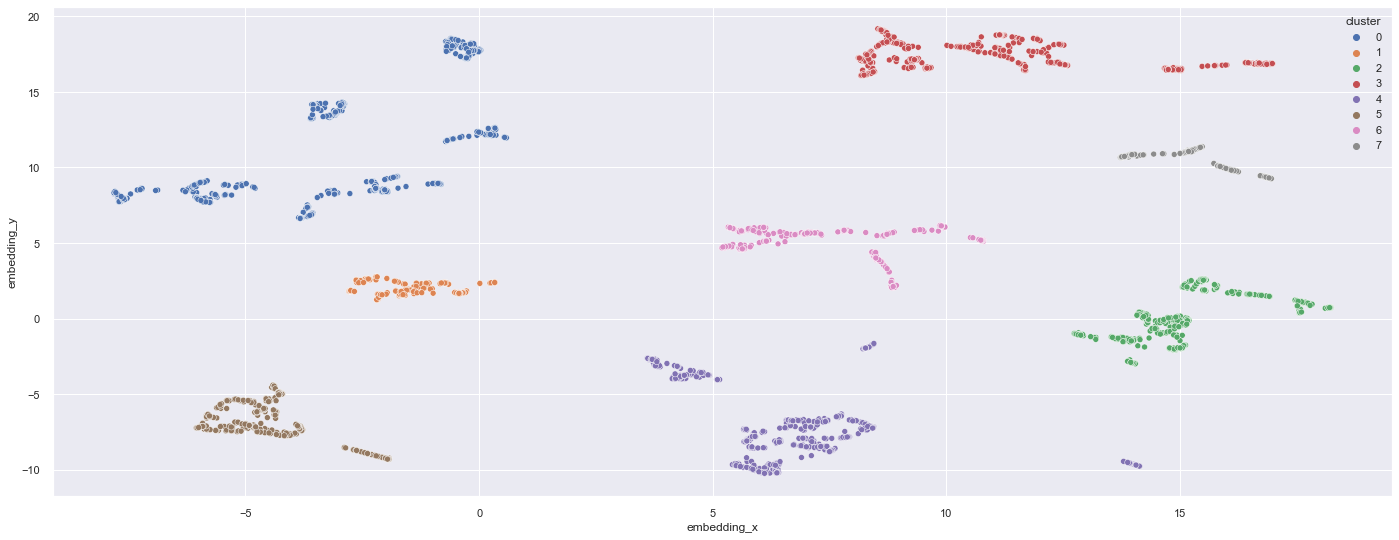

In [105]:
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', data=df9, palette='deep')

## 9.2 Visualization Silhouette Visualizer

C:\Users\t.mesha09\Anaconda3\envs\pa005-programa_de_fidelidade\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


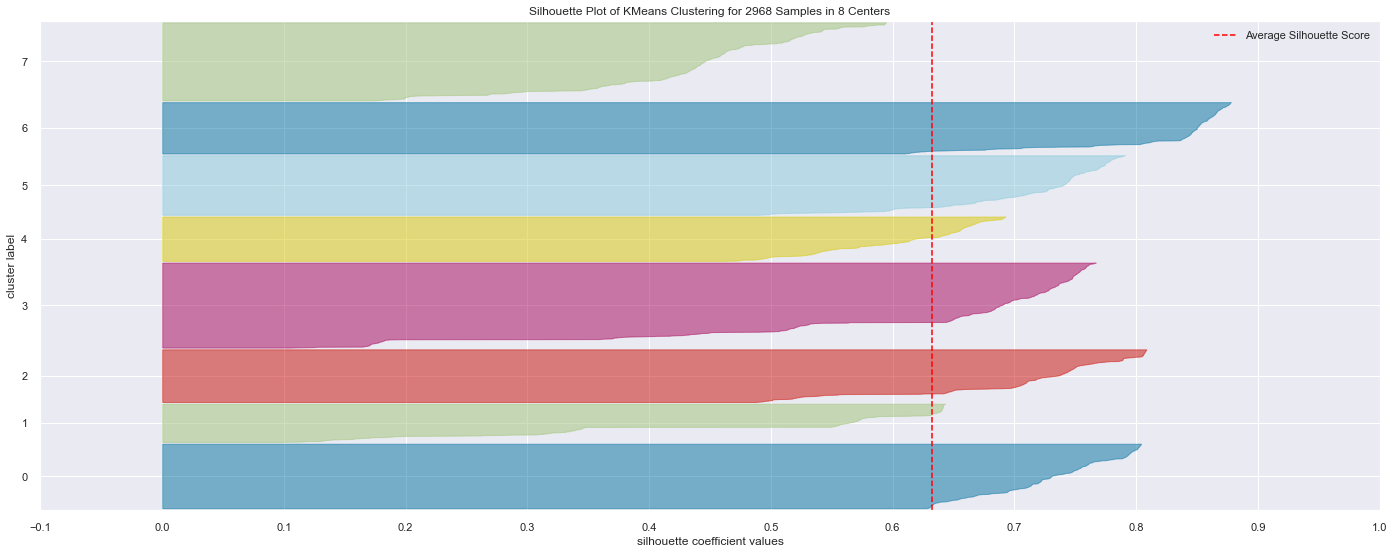

In [106]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

In [107]:
df_viz = df9.copy()
#sns.pairplot(df_viz, hue='cluster')

## 9.3 UMAP

In [108]:
#reducer = umap.UMAP(random_state=42)
#embedding = reducer.fit_transform(X)

# embedding
#df_viz['embedding_x'] = embedding[:,0]
#df_viz['embedding_y'] = embedding[:,1]

#plot UMAP
#sns.scatterplot(x='embedding_x', y='embedding_y', 
#                hue='cluster', 
#                palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())), 
#                data=df_viz)

## 9.4 Cluster Profile

In [109]:
df92 = df4[cols_selected].copy()
df92['cluster'] = labels
df92.head()

,customer_id,gross_revenue,recency_days,qtde_produtos,frequency,qtde_returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,3
1,13047,3232.59,56.0,171.0,0.028302,35.0,7
2,12583,6705.38,2.0,232.0,0.040323,50.0,3
3,13748,948.25,95.0,28.0,0.017921,0.0,1
4,15100,876.00,333.0,3.0,0.073171,22.0,0


In [110]:
# number of customer
df_cluster = df92[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id']/df_cluster['customer_id'].sum() )

# average gross revenue
df_avg_gross_revenue = df92[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_avg_gross_revenue, how='inner', on='cluster')

# average recency days
df_avg_recency_days = df92[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_avg_recency_days, how='inner', on='cluster')

# Avg Qtde Product
df_qtde_produtos = df92[['qtde_produtos','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_qtde_produtos, how='inner', on='cluster')

# frequency
df_frequency = df92[['frequency','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_frequency, how='inner', on='cluster')

# returns
df_qtde_returns = df92[['qtde_returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_qtde_returns, how='inner', on='cluster')


In [111]:
df_cluster.sort_values(by=['gross_revenue'], ascending=False)

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qtde_produtos,frequency,qtde_returns
3,3,468,15.768194,8836.136389,21.438034,424.134615,0.094571,149.271368
7,7,145,4.885445,3164.253379,34.427586,173.875862,0.060415,23.482759
6,6,330,11.118598,2515.687182,44.433333,128.430303,0.044853,21.466667
4,4,532,17.924528,2071.837105,57.614662,69.725564,0.047062,16.069549
2,2,404,13.611860,1689.182401,54.801980,89.202970,0.050037,11.542079
5,5,322,10.849057,971.025435,75.329193,37.462733,0.074586,6.571429
1,1,175,5.896226,827.478286,92.022857,26.822857,0.161952,22.868571
0,0,592,19.946092,553.770946,114.917230,14.167230,0.291256,6.538851


In [112]:
# 3. Cluster Insiders
# 7. Cluster More Products
# 6. Cluster Spend Money
# 4. Cluster Even More Products
# 2. Cluster Less Days
# 5. Cluster Stop Returners
# 1. Cluster Less 1k
# 0. Cluster More Buy

### Cluster Insider
    - Número de customers: 468 (15.76% dos customers)
    - Faturamento Médio: $8836,00
    - Recência Média: 21 dias
    - Média de Produtos Comprados: 468 produtos
    - Frequência de Produtos Comprados: 0.09 produtos/dia

# 10.0 Análise Exploratória de Dados

In [113]:
df10 = df92.copy()

## 10.2 Hipóteses de Negócio

1. Os Clientes do cluster insiders possuem um volume (produtos) de compra acima de 10% do total de compras.
2. Os Clientes do cluster insiders possuem um volume (faturamento) de compra acima de 10% do total de compras.
3. Os clientes do cluster insiders tem um número de devolução médio abaixo da média da base total de clientes.
4. A mediana dos faturamento pelos clientes do cluster insider é 10% maior que a mediana do faturamento geral.
5. O GMV dos clientes insiders está concentrados no terceiro quartil.

#### H1: Os Clientes do cluster insiders possuem um volume (produtos) de compra acima de 10% do total de compras.
**Verdade:** O cluster insider possui um volume de compra de produtos de 54%

In [114]:
# soma da qtde de produtos dos insiders
df_sales_insiders = df10.loc[df10['cluster']==3, 'qtde_produtos'].sum()

# soma do total
df_sales_total = df10.loc[:,'qtde_produtos'].sum()

# percentual
print(' % Sales Insiders: {:.2f}%'.format(100*df_sales_insiders/df_sales_total))

 % Sales Insiders: 54.48%


#### H2: Os Clientes do cluster insiders possuem um volume (faturamento) de compra acima de 10% do total de compras.
**Verdadeiro:** O cluster insider possui um volume de GMV de 49%

In [115]:
# soma da qtde de produtos dos insiders
df_gmv_insiders = df10.loc[df10['cluster']==3, 'gross_revenue'].sum()

# soma do total
df_gmv_total = df10.loc[:,'gross_revenue'].sum()

# percentual
print(' % GMV Insiders: {:.2f}%'.format(100*df_gmv_insiders/df_gmv_total))

 % GMV Insiders: 51.73%


#### H3: Os clientes do cluster insiders tem um número de devolução médio abaixo da média da base total de clientes.
**Falso:** O cluster insider tem a média de devoluções acima da média geral

In [116]:
df10.head()

,customer_id,gross_revenue,recency_days,qtde_produtos,frequency,qtde_returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,3
1,13047,3232.59,56.0,171.0,0.028302,35.0,7
2,12583,6705.38,2.0,232.0,0.040323,50.0,3
3,13748,948.25,95.0,28.0,0.017921,0.0,1
4,15100,876.00,333.0,3.0,0.073171,22.0,0


In [117]:
# media de devolucao do cluster insider
df_avg_return_insiders = df10.loc[df10['cluster'] ==3, 'qtde_returns'].mean()

# media de devolucao do total
df_avg_return_all = df10['qtde_returns'].mean()

#
print('Avg Return Insiders: {} vs Avg Return All: {}'.format(np.round(df_avg_return_insiders,0), np.round(df_avg_return_all,0)))

Avg Return Insiders: 149.0 vs Avg Return All: 35.0


#### H4: A mediana dos faturamento pelos clientes do cluster insider é 10% maior que a mediana do faturamento geral.
**Verdadeiro**: A mediana do faturamento é 276% acima da média

In [118]:
# mediana do gmv do insiders
df_median_gmv_insiders = df10.loc[df10['cluster'] == 3, 'gross_revenue'].median()

# mediana de gmv do total
df_median_gmv_total = df10.loc[:, 'gross_revenue'].median()

gmv_diff = (df_median_gmv_insiders - df_median_gmv_total) / df_median_gmv_total

print('Median Diff: {:.2f}%'.format(100*gmv_diff))

Median Diff: 276.48%


#### H5:O GMV dos clientes insiders está concentrados no terceiro quartil.
**Falso**: O faturamento do cluster insiders está concentrada no quartil 1.

In [119]:
np.percentile(df10.loc[df10['cluster'] == 3, 'gross_revenue'],q=0.1)

617.56155

In [120]:
np.percentile(df10.loc[df10['cluster'] == 3, 'gross_revenue'],q=0.9)

823.98433

<AxesSubplot:xlabel='gross_revenue'>

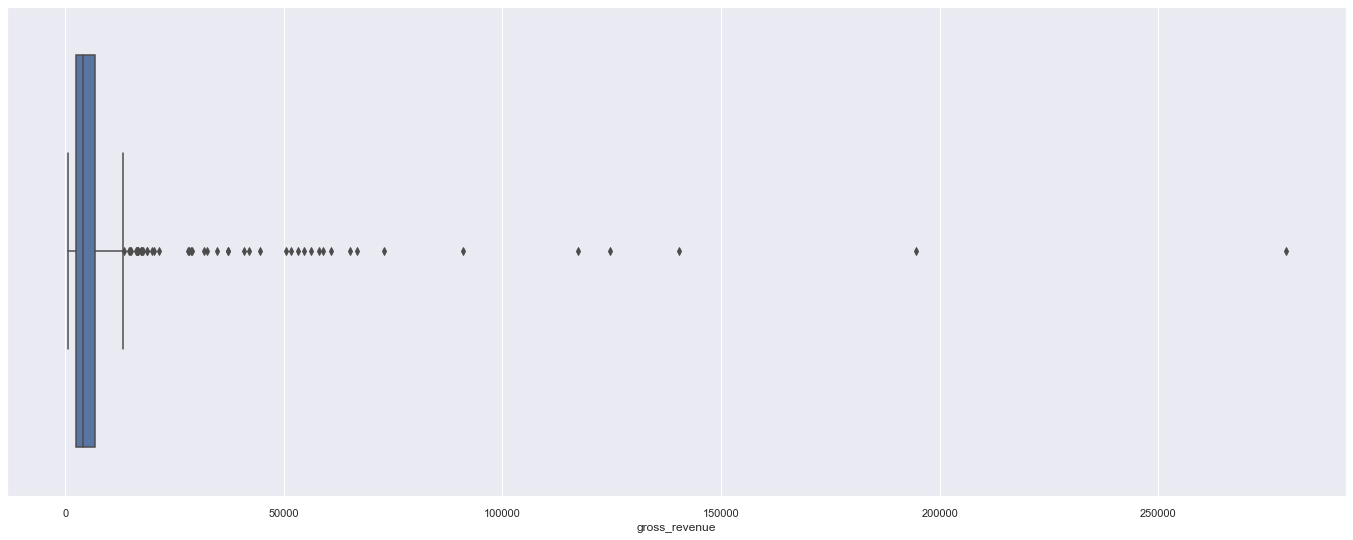

In [121]:
sns.boxplot(x=df10.loc[df10['cluster']==3, 'gross_revenue'])

<AxesSubplot:xlabel='gross_revenue'>

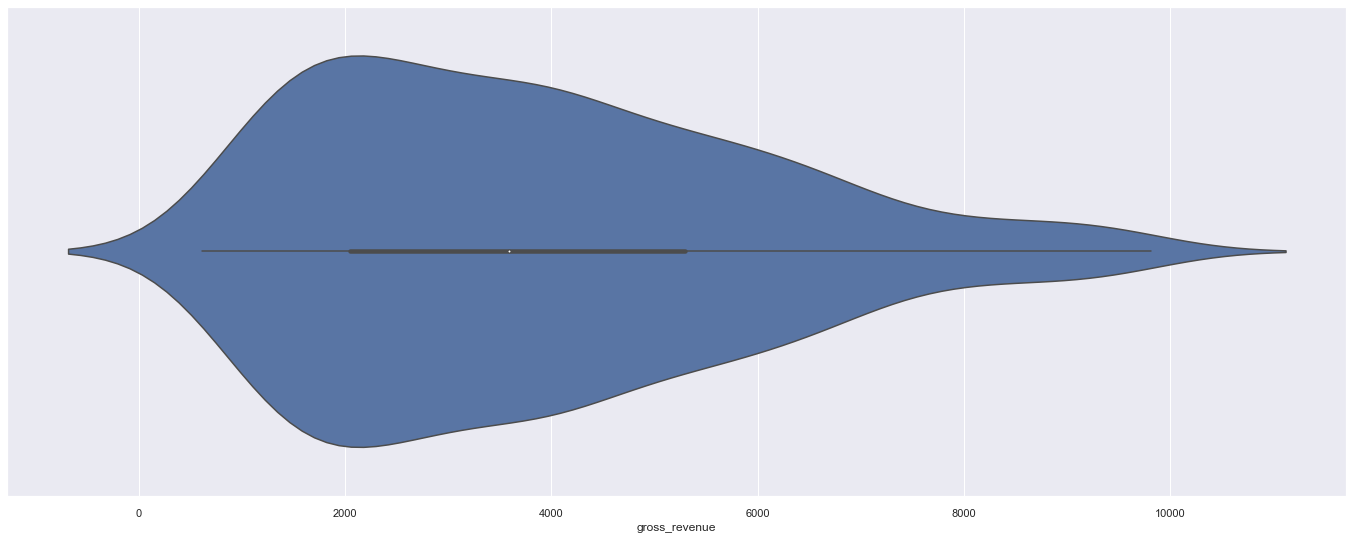

In [122]:
df_aux = df10.loc[(df10['cluster']==3) & (df10['gross_revenue']<10000), 'gross_revenue']
sns.violinplot(x=df_aux)

## 10.3 Perguntas de Negócio

#### 1. Quem são as pessoas elegíveis para participar do programa de Insiders ?

In [123]:
df10.head()

,customer_id,gross_revenue,recency_days,qtde_produtos,frequency,qtde_returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,3
1,13047,3232.59,56.0,171.0,0.028302,35.0,7
2,12583,6705.38,2.0,232.0,0.040323,50.0,3
3,13748,948.25,95.0,28.0,0.017921,0.0,1
4,15100,876.00,333.0,3.0,0.073171,22.0,0


In [124]:
df10.loc[df10['cluster'] == 3, 'customer_id'].head()

0     17850
2     12583
6     14688
8     15311
12    16029
Name: customer_id, dtype: int64

#### 2. Quantos clientes farão parte do grupo?

In [125]:
df10.loc[df10['cluster'] == 3, 'customer_id'].size

468

#### 3. Quais as principais características desses clientes ?

In [126]:
df_cluster.sort_values(by=['gross_revenue'], ascending=False)

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qtde_produtos,frequency,qtde_returns
3,3,468,15.768194,8836.136389,21.438034,424.134615,0.094571,149.271368
7,7,145,4.885445,3164.253379,34.427586,173.875862,0.060415,23.482759
6,6,330,11.118598,2515.687182,44.433333,128.430303,0.044853,21.466667
4,4,532,17.924528,2071.837105,57.614662,69.725564,0.047062,16.069549
2,2,404,13.611860,1689.182401,54.801980,89.202970,0.050037,11.542079
5,5,322,10.849057,971.025435,75.329193,37.462733,0.074586,6.571429
1,1,175,5.896226,827.478286,92.022857,26.822857,0.161952,22.868571
0,0,592,19.946092,553.770946,114.917230,14.167230,0.291256,6.538851


**Cluster Insider**:

    - Número de customers: 468 (15.76% dos customers)
    - Faturamento Médio: $8836,00
    - Recência Média: 21 dias
    - Média de Produtos Comprados: 468 produtos
    - Frequência de Produtos Comprados: 0.09 produtos/dia

#### 4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?

In [127]:
df_insiders_gmv = df10.loc[df10['cluster'] == 3,'gross_revenue'].sum()
df_all_gmv = df10.loc[:,'gross_revenue'].sum()

print( '% GMV From Insiders: {}'.format(df_insiders_gmv/df_all_gmv))

% GMV From Insiders: 0.5172848940036087


#### 5. Qual a garantia que o programa Insiders é melhor que o restante da base ?

Baseado na resposta 4, é possível ver que o faturamento do programa Insiders é de mais da metade da contribuição do faturamento da loja. Sendo assim, é uma parcela, apesar de pequena, que trás um retorno financeiro muito grande para empresa.

#### 6. Quais ações o time de marketing pode realizar para aumentar o faturamento?

As ações serão divididas por grupos e quais ações são **sugeridas**. Vale salientar que são apenas sugestões, a decisão final não é da equipe de ciência de dados.

In [128]:
df_cluster.sort_values(by=['gross_revenue'], ascending=False)

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qtde_produtos,frequency,qtde_returns
3,3,468,15.768194,8836.136389,21.438034,424.134615,0.094571,149.271368
7,7,145,4.885445,3164.253379,34.427586,173.875862,0.060415,23.482759
6,6,330,11.118598,2515.687182,44.433333,128.430303,0.044853,21.466667
4,4,532,17.924528,2071.837105,57.614662,69.725564,0.047062,16.069549
2,2,404,13.611860,1689.182401,54.801980,89.202970,0.050037,11.542079
5,5,322,10.849057,971.025435,75.329193,37.462733,0.074586,6.571429
1,1,175,5.896226,827.478286,92.022857,26.822857,0.161952,22.868571
0,0,592,19.946092,553.770946,114.917230,14.167230,0.291256,6.538851


##### Cluster 3: Cluster Insiders

É possível observar que este cluster é o com maior receita, entretanto, tem uma baixa frequencia de compras e uma alta quantidade de retornos. Uma sugestão seria limitar a quantidade de produtos retornados, evitando assim prejuízos para a loja.

##### Cluster 7

Uma sugestão seria aumentar a quantidade de produtos vendidos, uma vez que, em relação ao cluster insiders, a quantidade de produtos compradas é menos da metade. Uma sugestão é utilizar cross-sell, sugerindo alguns produtos juntamente com os que estão sendo comprados.

##### Cluster 6

Este é um grupo de pessoas que talvez seja interessante aumentar a frequência de compras. Como sugestão, enviar cupons de desconto para atrair os clientes mais vezes.

##### Cluster 4

Neste caso, um aumento na quantidade de compras seria interessante, uma vez que a quantidade de compras é baixa. Cross-sell unido com cupons de desconto podem ajudar este grupo a comprar mais.

##### Cluster 2

Aumentar a quantidade de vezes compradas (recency) é o ideal para alavancar ainda mais este grupo. Estar sempre enviando e-mail com as principais ofertas pode ajudar.

##### Cluster 5, 1 e 0

Tods os três grupos estão com um gross-revenue abaixo de 1k, ou seja, é importante aumentar o quanto é gasto na loja. Isto pode ser feito melhorando o tempo entre as compras ou aumentando a quantidade de produtos comprados. 

# 11.0 Deploy to Production